# Predictive Modeling and Analysis using Bayesian Networks

This code uses the dataset from the Kaggle competition [Diagnosis of COVID-19 and its clinical spectrum](https://www.kaggle.com/einsteindata4u/covid19/data?). Its purpose is to serve as an introduction to Bayesian Networks and how they can be used for probabilistic decision making.

**Table of contents**
* [Introduction to Bayesian Networks](#intro)  
* [Preliminaries](#preliminaries)
    * [pyAgrum](#pyagrum)
    * [Standard imports and functions](#standard)
    * [Wrapper class](#wrapper)
* [Application to COVID-19 dataset](#appli)
    * [Network construction](#constr)
    * [Prior knowledge](#prior)
    * [Memory gains](#memory)




<a id='intro'></a>
## Introduction to Bayesian Networks

Bayesian Networks (BNs) are class of Probabilistic Graphical Models that are popular in the AI community for their capabilities to reason under uncertainty. 
They can be seen as a probabilistic expert system: the domain knowledge (business knowledge) is modeled as direct acyclic graph (DAG). The DAG links (arcs) represent the probabilistic dependencies (correlation, causation or influence) between nodes/variables in the domain.

More formally, A BN is a Joint Probability Distribution (JPD) over a set of random variables. It is represented by a DAG, where the nodes are identifed with random variables and arcs express the probabilistic dependence between them. 

To put BN in perspective, let's consider the following thought experiment. Consider an Intensive Care Unit of a hospital in the current pandemic. Healthcare professionals need to have an idea of whether or not a person will require intensive care in the immediate future to better allocate their resources more in moments of great strain. The admission to ICU can due to Covid-19 or not. Some bioindicators are currently associated with a higher probability of having Covid-19, and can be relatively easily identified through a blood test (as shown in this [paper](https://www.researchgate.net/publication/339627510_Laboratory_abnormalities_in_patients_with_COVID-2019_infection) by Lippi and Plebani [2020]). Similarly, other indicators not necessarily linked to Covid-19 can also be related to other commorbidities that increase the probability of being admitted to ICU.

The BN factorizes the JPD **$P$** as the product of these CPTs, in other words:

$$
P(Bordetella pertussis, Adenovirus, CoronavirusNL63, Coronavirus HKU1, ... , Parainfluenza 1, Chlamydophilia pneumoniae) = \\
P(Bordetella pertussis)\\
\times P (Adenovirus | Bordetella pertussis)\\
\times P(CoronavirusNL63 | Adenovirus, Bordetella pertussis)\\
\times P(Coronavirus HKU1 | CoronavirusNL63, Bordetella pertussis)\\
\times ... \times \\
\times P (Parainfluenza 1 | Bordetella pertussis, Rhinovirus/Entenovirus)\\
\times P(Chlamydophilia pneumoniae | Parainfluenza 1, Bordetella pertussis)
$$

We can obtain these CPT, using a frequentist approach by learning them from a historical dataset or elicitation an expert knowledge or both.

The graphical structure encodes very interesting information that can be used to derive insight about the data. 
For example every node is conditionally independent of its non-descendants given its parents in the DAG. This is **Markovien property** in the BN. 


BNs have been successfully implemented in the industry and we found many applications in :

* Risk assessment (cancer, water, nuclear safety …)
* Industrial process simulation/ bourse prediction
* Monitoring the health of machines (troubleshouting, defect, failure etc ..)
* Predictive maintenance

In general applications we use BN for diagnosis, prediction and probable explanation of an observation. Once we have the BN, i.e, the graphical structure and the quantitative parameter (CPTs), we can start reasoning under uncertainty, aka the probabilistic inference. 
The latter consist of computing posterior such as `P(covid_19 = 1 | Platelets = 3, Influenza B = not_detected)` 

In general, the most important advantages of using BNs are:

* Efficient probabilistic reasoning and predictive modelling 
* BNs are a transparent tool vs challenges in explaining other ML models 
* Holistic representation of the system : learn a single model for all features of the domain (dataset)
* Useful in data driven decisions that might be blind w.r.t causation (e.g., Simpson’s paradox )
* Not data hungry
* Can be used to discoval causal and association in the data
* Classification (with moderation) 

The power of BNs relies on their modeling of probabilistic interaction in complex systems, where human reasoning is weak. 
BNs mathematically sound and are grounded in theory to have a normative approach to deal with uncertainty. 
However, they are not really a power tools for classfication tasks in general, although they can used as classifier. This is due to the loss of information we impose by discretizing variable. 
This is an ongoing reserach in the community to optimize the discretiztion of continous variables. 
Based the probabilistic dependencies encoded in the DAG, they used only subset of nodes (the Markov blanket) to make the classification actually. 


<a id='preliminaries'></a>

## Preliminaries

<a id='pyagrum'></a>
### pyAgrum
We base our analysis in this notebook on the open source pyAgrum https://pyagrum.readthedocs.io/en/0.17.2/


In [1]:
#!pip install pyagrum pydotplus

<a id='standard'></a>
### Standard imports and functions

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
from pylab import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC
from collections import Counter
from IPython.core.display import display, HTML
import time
import logging

# Some formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 4 decimal points
pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Path
path = ''

<a id='wrapper'></a>
### Wrapper class
We use a wrapper class to collect all the functions we need for our analysis (and a bit more :) )

In [3]:
# Wrapper class
class BNEstimator(BaseEstimator, ClassifierMixin):
    """
    csv_template is used to create the modalities for the BN"""
    def __init__(self,
                 csv_template=None,
                 bn=None,
               mandatory_arcs=[],
               tabu_arcs=[],
               class_name = None,
               learning_method='greedy',
               prior='likelihood', 
               prior_weight=.5, 
               positif_label = None,
               threshold = .5,
               nb_classes = 2,               
               cut_points_percentiles  = list(100*np.linspace(0, 1,5)),
               bins=5):
        
        
        self.csv_template = csv_template
        self.mandatory_arcs = mandatory_arcs
        self.tabu_arcs = tabu_arcs
        self.class_name = class_name
        self.learning_method = learning_method
        self.prior = prior
        self.prior_weight = prior_weight
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_points_percentiles = cut_points_percentiles
        self.bins = bins
        self.bn = bn
    
    
    def get_params(self, deep=True):
        return {"csv_template":self.csv_template,# template for modalities
            "class_name":self.class_name,
            "mandatory_arcs": self.mandatory_arcs,
                "tabu_arcs":self.tabu_arcs,
                "learning_method": self.learning_method, 
               "prior": self.prior,
               "prior_weight":  self.prior_weight,
              "class_name"  :self.class_name ,
              "positif_label"  :self.positif_label ,
              "threshold" : self.threshold ,
              "nb_classes"  :self.nb_classes ,
              "cut_points_percentiles"  :self.cut_points_percentiles,
            "bins" : self.bins}

    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
     
    def transform(self,d):
        """Transfrom the whole dataset before training
        param d : dataframe 
        """
        template = gum.BayesNet()
        numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
        categorical_cols = list(d.select_dtypes(include=[object]).columns)

        
        for col in numeric_cols:
            if d[col].value_counts().shape[0]>self.bins:
                x = d[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_points_percentiles)
                d.loc[:,col]= np.digitize(x, cut_points, right=False)   
                del x
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index)))) 
        for col in categorical_cols:
            if d[col].value_counts().shape[0]>self.bins:
                top = d[col].isin(d[col].value_counts().index[:self.bins])
                d.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        return template,d
        
        
    def fit(self,data,y=None):
        """Create the template and Fit the training dataset: data_file"""
        
        # create the template   
        template,_ = self.transform(pd.read_csv(self.csv_template))
        _,train= self.transform(data)
                
            
        train.to_csv('train_bn.csv',index=False)
        learner = gum.BNLearner('train_bn.csv', template)

        
        for i in self.tabu_arcs: learner.addForbiddenArc(i[0],i[1])
        for i in self.mandatory_arcs :  learner.addMandatoryArc(i[0],i[1])

        if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
        else: learner.useMIIC()

        if self.prior == "laplace":learner.useAprioriSmoothing(self.prior_weight)
        else:learner.useNoApriori()
            
        
        self.bn = learner.learnBN()
        self.bn = learner.learnParameters(self.bn.dag())        
        del template,train

        return self
   
    def predict_one_row(self,row):
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        evs = row.astype(str).to_dict()
        del evs[self.class_name]      
        ie.setEvidence(evs)
        ie.makeInference()
        return ie.posterior(self.class_name).toarray()
        
       
    def predict_proba1(self,test):#,mb=True):
        scores = np.empty([test.shape[0], self.nb_classes])
        scores[:] = np.nan
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        for i in range(len(test)):    
            evs = test.iloc[i,:].astype(str).to_dict()
            del evs[self.class_name]               
            ie.setEvidence(evs)
            ie.makeInference()
            scores[i] = ie.posterior(self.class_name).toarray()
        return scores

   
    def predict_proba(self, Xtest):
        if type(Xtest) is np.ndarray:
            Xtest = pd.DataFrame(Xtest, columns=["X{}".format(i) for i in range(Xtest.shape[1])])

        Yscores = np.empty([Xtest.shape[0], self.nb_classes])
        Yscores[:] = np.nan

        mbnames = [self.bn.variable(i).name()
                   for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()
                   if self.bn.variable(i).name() != self.class_name]
        ie = gum.LazyPropagation(self.bn)
        for var in ie.BN().names():  
            if var != self.class_name:
                ie.addEvidence(var, 0)
        ie.addTarget(self.class_name)

        Xtest = Xtest.reset_index(drop=True)

        for line in Xtest.itertuples():
            for var in mbnames:
                try:
                    idx = self.bn.variable(var).index(str(getattr(line, var)))
                    ie.chgEvidence(var, idx)
                except gum.GumException:
                # this can happen when value is missing is the test base.
                    print("[pyAgrum] ** pyAgrum.lib.classifier : The value {getattr(line, var)} for the variable {var} is missing in the training set.")
                    pass

            ie.makeInference()

            marginal = ie.posterior(self.class_name)
            Yscores[line[0]] = marginal.toarray()

        return Yscores
    
    
    def predict(self,test):
        y_scores = self.predict_proba(test)[:,1]
        y_true = test[self.class_name]
        
        return y_true, np.where(y_scores >= self.threshold, 1, 0)
    
 
    def score(self,test):
        from sklearn.metrics import recall_score, f1_score, classification_report
        y_true,y_pred = self.predict(test)
        print(classification_report(y_true, y_pred))
        print(5*'--')
        print('recall_score')
        return recall_score(y_true, y_pred)

<a id='appli'></a>
## Application to the COVID-19 dataset

<a id='constr'></a>
### Network construction
Both the structure and the parameters (CPTs) of a BN can be learnt from dataset. In this application, we use the dataset from the Kaggle competition [Diagnosis of COVID-19 and its clinical spectrum](https://www.kaggle.com/einsteindata4u/covid19/data?) as a set of random variables with probabilistic interactions. This competition was promoted by the Hospital Israelita Albert Einstein in Sao Paulo, Brazil. Its aim is to shed some light on how to diagnose Covid-19 cases from a range of bioindicators taken from patients upon admission to the hospital. 
Let's first read the dataset

By running our function `missing` on the whole dataframe, we can see that almost all columns have some missing values. In some cases, up to 99% of the values are missing, so we can safely drop these columns. We can also drop all those columns that have only one value (other than `NaN`). These columns do not present any variation and hence can't be use for prediction.

In [4]:
#df.drop(columns = list(missing(df, perc = 95).column.values), inplace = True)
#df.drop(columns = list(show_unique(df).index), inplace = True)
#df.shape  

We will make a further simplification assumption and keep only those columns with less than 4 different values (states). To illustrate the discretisation of continuous variables, we will also keep four extra continous variable, which will be discretised by our wrapper class. When we initiate the class, we will take four asymmetrically bounded buckets. Given our amount of missings is substantial and that we filled values with the median, we are interested mostly in the variations in the extremes of the distribution. Therefore, our first bucket is bounded by percentiles 0 and 5, whereas our last bucket is bounded by percentiles 95 and 100. Everything in between split by percentile 50, forming our two middle buckets.


We do this merely because of the educational purpose of this notebook. In reality, whether or not to keep a column or how to keep it is entirely up to the criterion of the practitioner.

In [5]:
#kept_cols = [i for i in df if df[i].nunique()<=4]
#kept_cols.extend(['Platelets','Red blood Cells','Lymphocytes','Leukocytes'])
#kept_cols,len(kept_cols)

In [6]:
#missing(df_orig)

In [7]:
#df = df[kept_cols]
#missing(df)

`pyAgrum` cannot deal with missing values by itself, so we need to fill them before constructing the Bayesian Network. We will fill them differently, depending on whether the column is discrete (dummy varibles and objects) or continous. Discrete variables will be filled with the value `-999`, while continuous variables will be filled with the median of the median. 

Filling discrete variables with `-999` effectively creates another category. Filling continous variables with the median ensures that we are still able to capture the variation in the non-filled values when we discretise them.

In [8]:
#continuous_cols = [x for x in df.columns if df[x].dtypes == 'float64']
#discrete_cols = [x for x in df.columns if (df[x].dtypes == 'O') | (df[x].dtypes == 'int64')]
#for i in ['covid_19', 'regular_ward', 'semi_intensive_care','intensive_care']:
#    discrete_cols.remove(i)  # Drop targets

#df = fill_null(df, continuous_cols, stat = 'median')
#df = fill_null(df, discrete_cols, stat = 'integer', integer = '-999')

Now we are ready to initialise our first BN, so let's have a look!

In [9]:
import pandas as pd

In [10]:
df=pd.read_csv('reducedCovidDataset.csv')
df.head()

,covid_19,regular_ward,semi_intensive_care,intensive_care,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Influenza B rapid test,Influenza A rapid test,Strepto A,Platelets,Red blood Cells,Lymphocytes,Leukocytes
0,0,0,0,0,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-0.122,0.014,-0.014,-0.213
1,0,0,0,0,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,-999,-0.517,0.102,0.318,-0.095
2,0,0,0,0,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-0.122,0.014,-0.014,-0.213
3,0,0,0,0,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-0.122,0.014,-0.014,-0.213
4,0,0,0,0,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-999,-999,-999,-0.122,0.014,-0.014,-0.213


In [11]:
#df.to_csv(path + 'template.csv', index = False)
path=""
clf = BNEstimator(csv_template=path+'template.csv', class_name='covid_19',
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data ,test_size=0.25, random_state=42)
train.to_csv(path +'train.csv',index=False)

clf.fit(train)

BNEstimator(class_name='covid_19', csv_template='template.csv',
            cut_points_percentiles=[5, 50, 95])

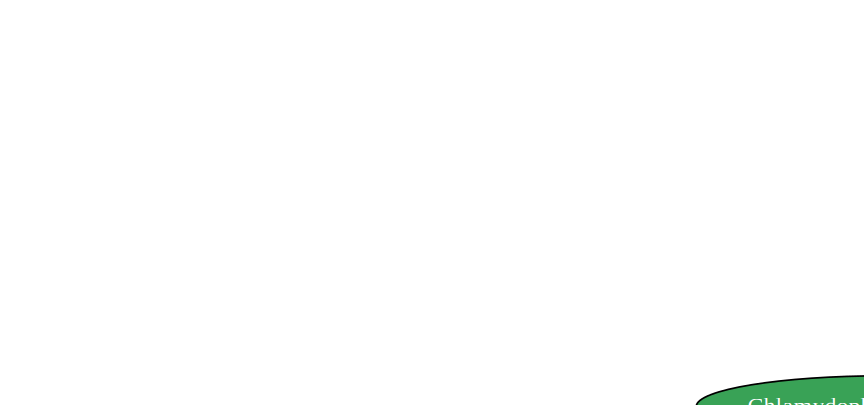

In [12]:
gnb.showBN(clf.bn,size=12,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Greens'))

The learned structure may contain some relation that doesn't make sense from a practical point of view. Here is another important feature of BN, where domain expert can intervene to encode the business knwoledge in the learning process. Our framework allows us to add those constrains to the learning algorithms. Additionally, thinking in terms of prediction, we may want to enforce certain arcs from some predictive variables to our target variable(s). 

Let's enforce some tabu and mandatory arcs to see how our network changes.

Now we are ready to take a look at the learnt features of our BN. Let's first see the CPT for the variable `regular_ward`

In [13]:
clf.bn.cpt(clf.bn.idFromName('regular_ward'))

(gum::Potential<double>@0x7fa5b2b939d0) 
             ||  regular_ward     |
Influe|covid_||0        |1        |
------|------||---------|---------|
-999  |0     || 0.9975  | 0.0025  |
not_de|0     || 0.9705  | 0.0295  |
detect|0     || 0.9983  | 0.0017  |
-999  |1     || 0.9795  | 0.0205  |
not_de|1     || 0.7495  | 0.2505  |
detect|1     || 0.9286  | 0.0714  |

We can also have a look at the corresponding Markov Blanket our variables. Let's have a look at the variable `covid_19`.

In [14]:
gum.MarkovBlanket(clf.bn,'covid_19')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7fa5b2454db0> >

<a id='prior'></a>
### Prior knowledge
Our Bayesian Network allows us to ask questions of the type _What's the probability that a patient tests positive for COVID-19 given that she presents this clinic picture?_ The overall probabilities for the whole network looks like this:

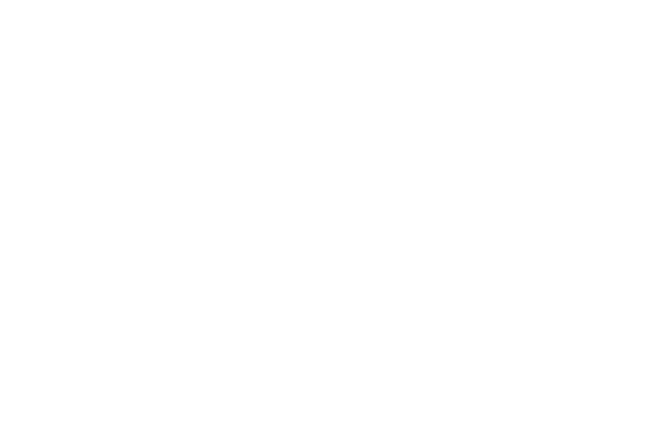

In [15]:
gnb.showInference(clf.bn,size=9)

If we are interested in (or just know) some particular variables, we can also show the posterior of our target variable conditional on these variables.

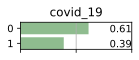

In [16]:
gnb.showPosterior(clf.bn, evs={'Platelets':'3', 'Influenza B':'detected', 'Coronavirus HKU1':'not_detected'},
                 target='covid_19')# we specify the target we want to analyse

It is worth noting that the probabilistic engine used only nodes from the Markov Blanket to derive such information. To verify this, let's first observe the so called Markov Blanket and add a new observation from a node outside of it. Then let's see the effect on the prediction.

In [17]:
gum.MarkovBlanket(clf.bn,'covid_19')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7fa5b3b7fa50> >

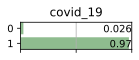

In [18]:
d_test = pd.read_csv(path + 'test.csv')
row = d_test.loc[1,:]
evs = row.astype(str).to_dict()

evidence = {'Platelets': '3',
            'Inf A H1N1 2009': 'not_detected',
            'Influenza B': 'detected',
            'Respiratory Syncytial Virus': 'detected',
            'Coronavirus HKU1': 'detected',
            'Rhinovirus/Enterovirus': 'not_detected',
            'regular_ward': 0
           }

gnb.showPosterior(clf.bn,
                 target='covid_19',
                 evs=evidence)

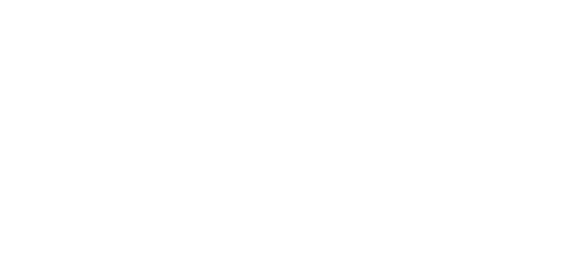

In [19]:
MB = gum.MarkovBlanket(clf.bn,'covid_19')

gnb.showInference(clf.bn, 
                  nodeColor={n:0.9 for n in clf.bn.names()},
                  evs=evidence,
                  targets={'covid_19'},
                  size=8)

Let's now add an observation of a node outide of the MB and see the change

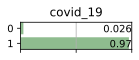

In [20]:
from  random import choice
id = choice(list(clf.bn.nodes().difference(MB.nodes())))
gnb.showPosterior(clf.bn,                             
                  evs={'Platelets': '3',
                        'Inf A H1N1 2009': 'not_detected',
                        'Influenza B': 'detected',
                        'Respiratory Syncytial Virus': 'detected',
                        'Coronavirus HKU1': 'detected',
                        'Rhinovirus/Enterovirus': 'not_detected',
                        'regular_ward': 0,
                      clf.bn.variable(id).name():1}, 
                  target= 'covid_19') 

As we can see there is no effect on the prediction. We can play by adding another observation for the sake of a second example. 

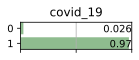

In [21]:
from  random import choice
id1 = choice(list(clf.bn.nodes().difference(MB.nodes())))
id2 = choice(list(clf.bn.nodes().difference(MB.nodes())))

gnb.showPosterior(clf.bn, # we specify the BN to reason with
                  evs={'Platelets': '3',
                        'Inf A H1N1 2009': 'not_detected',
                        'Influenza B': 'detected',
                        'Respiratory Syncytial Virus': 'detected',
                        'Coronavirus HKU1': 'detected',
                        'Rhinovirus/Enterovirus': 'not_detected',
                        'regular_ward': 0,
                      clf.bn.variable(id1).name():1,
                      clf.bn.variable(id2).name():0},## observe outside of MB
                  target= 'covid_19')

<a id='memory'></a>
### Memory gains

What about memory gains? To store the JPD we need to store `6347497291776` entries, which the product of all modality sizes in the JPD    

In [22]:
get_jpd_size(clf.bn)

NameError: name 'get_jpd_size' is not defined

Using the BN, we can encode this compactly as we saw in the factorisation above and we need to store only : 

In [23]:
get_cpts_size(clf.bn)

636

Which represent a memory gain of:

In [24]:
compression_ratio(clf.bn)

99.99999998998031